In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# !wget -q http://archive.apache.org/dist/spark/spark-3.1.1/spark-3.1.1-bin-hadoop3.2.tgz
!tar xf /content/drive/MyDrive/spark-3.1.1-bin-hadoop3.2.tgz
!pip install -q findspark

In [ ]:
!apt-get install openjdk-8-jdk-headless -qq > /dev/null

In [ ]:
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-3.1.1-bin-hadoop3.2"

In [ ]:
import findspark
findspark.init()

In [ ]:
import pyspark as spark
print(spark.__version__)

3.1.1


In [ ]:
from pyspark import SparkContext,SparkConf
from pyspark.sql import SparkSession
from pyspark.sql.types import StringType
from pyspark.ml.fpm import FPGrowth
import pyspark.sql.functions as F
import matplotlib.pyplot as plt
import findspark
import os
import pyspark.sql.functions as F
from pyspark.sql.window import Window
from itertools import combinations
from functools import reduce

In [ ]:
# sc.stop

In [ ]:
conf = SparkConf().setAppName("gk")
sc = SparkContext.getOrCreate(conf=conf)

In [ ]:
findspark.init()

In [ ]:
print(spark.__version__)

3.1.1


In [ ]:
def f1(path):
    rdd = sc.textFile(path)

    header = rdd.first()
    rdd = rdd.filter(lambda line: line != header)

    items_rdd = rdd.map(lambda line: line.split(','))
    unique_items = items_rdd.map(lambda x: x[2]).distinct().sortBy(lambda x: x.lower())
    output_path = "f1"
    if sc._jvm.org.apache.hadoop.fs.FileSystem.get(sc._jsc.hadoopConfiguration()).exists(sc._jvm.org.apache.hadoop.fs.Path(output_path)):
       sc._jvm.org.apache.hadoop.fs.FileSystem.get(sc._jsc.hadoopConfiguration()).delete(sc._jvm.org.apache.hadoop.fs.Path(output_path), True)
    unique_items.coalesce(1).saveAsTextFile(output_path)
    first_10_names = unique_items.take(10)
    for name in first_10_names:
        print(name)

    # Lấy 10 tên cuối cùng
    unique_items_opposite= unique_items.sortBy(lambda x: x.lower(),ascending=False)
    last_10_names=unique_items_opposite.take(10)[::-1]
    print("--------------------------")
    for name in last_10_names:
        print(name)

In [ ]:
def f2(path):

    rdd = sc.textFile(path)

    header = rdd.first()

    rdd = rdd.filter(lambda line: line != header)

    items_rdd = rdd.map(lambda line: line.split(','))

    item_counts = items_rdd.map(lambda x: (x[2], 1)).reduceByKey(lambda a, b: a + b)

    sorted_items = item_counts.sortBy(lambda x: x[1], ascending=False)

    output_path = "f2"
    if sc._jvm.org.apache.hadoop.fs.FileSystem.get(sc._jsc.hadoopConfiguration()).exists(sc._jvm.org.apache.hadoop.fs.Path(output_path)):
       sc._jvm.org.apache.hadoop.fs.FileSystem.get(sc._jsc.hadoopConfiguration()).delete(sc._jvm.org.apache.hadoop.fs.Path(output_path), True)
    output_rdd = sorted_items
    output_rdd.coalesce(1).saveAsTextFile(output_path)

    top_items = sorted_items.take(100)

    item_names = [item[0] for item in top_items]
    item_counts = [item[1] for item in top_items]
    plt.figure(figsize=(15, 6))
    plt.bar(item_names, item_counts, width=1)
    plt.xlabel('Món hàng')
    plt.ylabel('Số lần mua')
    plt.title('Top 100 món hàng được mua nhiều nhất')
    plt.xticks(rotation=90)
    plt.show()

In [ ]:
def f3(path):
    rdd = sc.textFile(path)

    header = rdd.first()
    rdd = rdd.filter(lambda line: line != header)

    data_rdd = rdd.map(lambda line: line.split(','))

    user_counts = data_rdd.map(lambda x: ((x[0], x[1]), 1)).reduceByKey(lambda a, b: a).map(lambda x: (x[0][0], 1)).reduceByKey(lambda a, b: a + b)
    sorted_users = user_counts.sortBy(lambda x: x[1], ascending=False)

    output_path = "f3"
    if sc._jvm.org.apache.hadoop.fs.FileSystem.get(sc._jsc.hadoopConfiguration()).exists(sc._jvm.org.apache.hadoop.fs.Path(output_path)):
       sc._jvm.org.apache.hadoop.fs.FileSystem.get(sc._jsc.hadoopConfiguration()).delete(sc._jvm.org.apache.hadoop.fs.Path(output_path), True)
    sorted_users.coalesce(1).saveAsTextFile(output_path)

    top_users = sorted_users.take(100)

    user_names = [user[0] for user in top_users]
    basket_counts = [user[1] for user in top_users]

    plt.figure(figsize=(20, 6))
    plt.bar(user_names, basket_counts)
    plt.xlabel('Người dùng')
    plt.ylabel('Số lượng giỏ hàng')
    plt.title('Top 100 người dùng mua nhiều giỏ hàng nhất')
    plt.xticks(rotation=90)
    plt.show()

In [ ]:
def f4(path):
    rdd = sc.textFile(path)

    header = rdd.first()
    rdd = rdd.filter(lambda line: line != header)

    data_rdd = rdd.map(lambda line: line.split(','))

    user_item_counts = data_rdd.map(lambda x: (x[0], x[2])).distinct().map(lambda x: (x[0], 1)).reduceByKey(lambda a, b: a + b)

    user_most_items = user_item_counts.sortBy(lambda x: x[1], ascending=False).first()

    print("Người dùng mua nhiều món hàng phân biệt nhất:")
    print("Mã người dùng:", user_most_items[0])
    print("Số lượng món hàng:", user_most_items[1])

    item_user_counts = data_rdd.map(lambda x: (x[2], x[0])).distinct().map(lambda x: (x[0], 1)).reduceByKey(lambda a, b: a + b)

    item_most_users = item_user_counts.sortBy(lambda x: x[1], ascending=False).first()

    print("Món hàng được mua bởi nhiều người dùng nhất:")
    print("Tên món hàng:", item_most_users[0])
    print("Số lượng người mua:", item_most_users[1])

    output_path = "f4"
    if sc._jvm.org.apache.hadoop.fs.FileSystem.get(sc._jsc.hadoopConfiguration()).exists(sc._jvm.org.apache.hadoop.fs.Path(output_path)):
       sc._jvm.org.apache.hadoop.fs.FileSystem.get(sc._jsc.hadoopConfiguration()).delete(sc._jvm.org.apache.hadoop.fs.Path(output_path), True)
    output_rdd = sc.parallelize(user_most_items + item_most_users)
    output_rdd.coalesce(1).saveAsTextFile(output_path)

In [ ]:
path = "/content/drive/MyDrive/baskets.csv"

In [ ]:
f1(path)

abrasive cleaner
artif. sweetener
baby cosmetics
bags
baking powder
bathroom cleaner
beef
berries
beverages
bottled beer
--------------------------
UHT-milk
vinegar
waffles
whipped/sour cream
whisky
white bread
white wine
whole milk
yogurt
zwieback


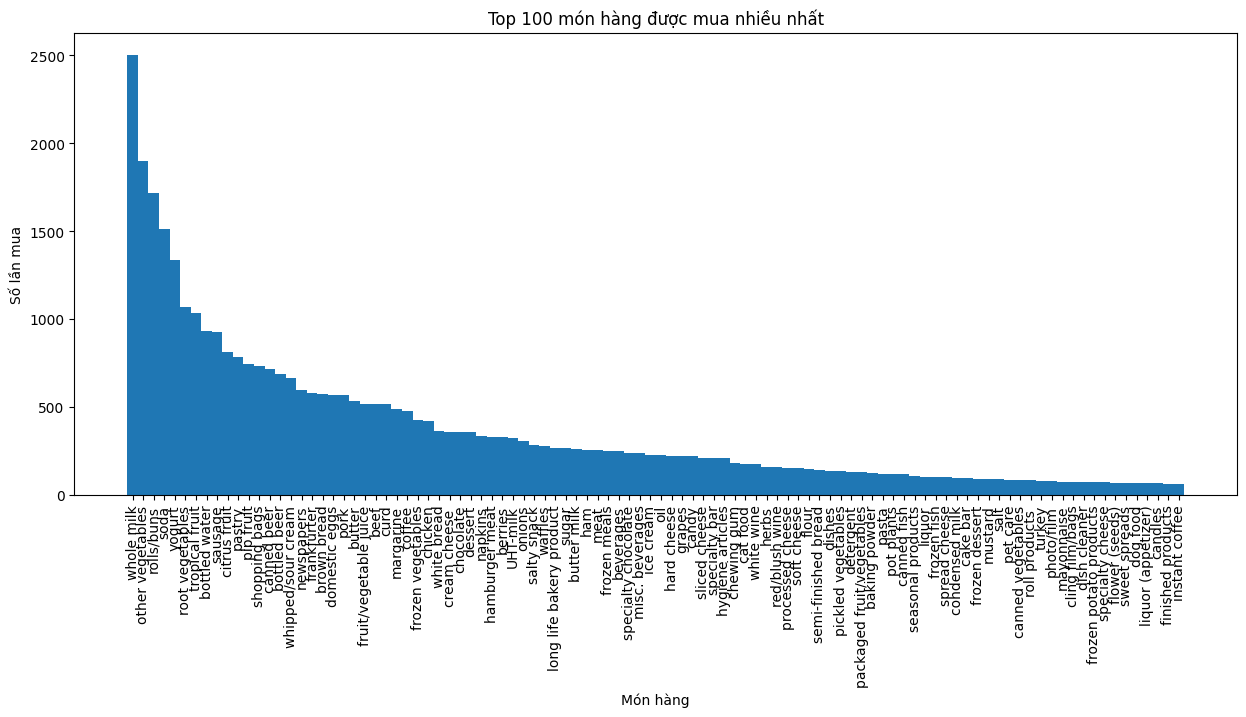

In [ ]:
f2(path)

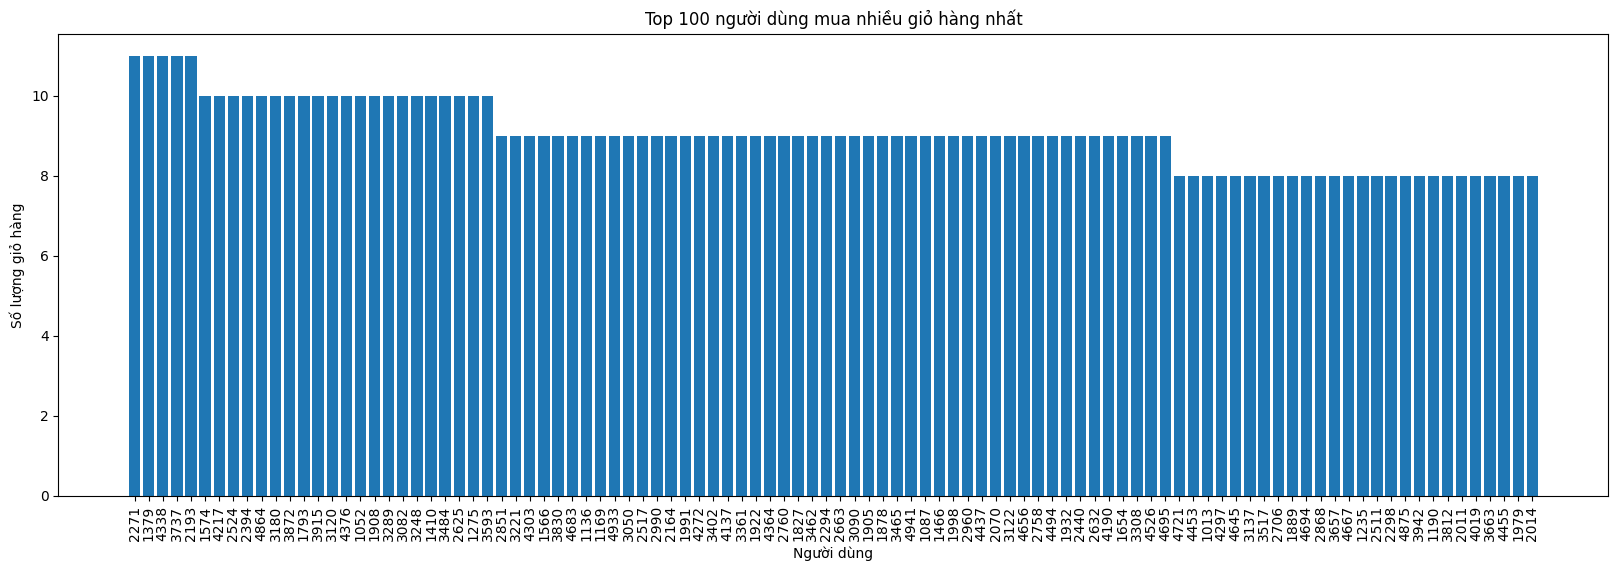

In [ ]:
f3(path)

In [ ]:
f4(path)

Người dùng mua nhiều món hàng phân biệt nhất:
Mã người dùng: 2051
Số lượng món hàng: 26
Món hàng được mua bởi nhiều người dùng nhất:
Tên món hàng: whole milk
Số lượng người mua: 1786


In [ ]:
sc.stop()

In [ ]:
!sudo rm -r /content/baskets

rm: cannot remove '/content/baskets': No such file or directory


In [ ]:
spark = SparkSession.builder.getOrCreate()

df = spark.read.csv(path, header=True)

df_basket = df.groupBy("Member_number","Date","year","month","day").agg(F.collect_set("itemDescription").alias("Basket"))

df_basket = df_basket.withColumn("year", F.col("year").cast("integer"))
df_basket = df_basket.withColumn("month", F.col("month").cast("integer"))
df_basket = df_basket.withColumn("day", F.col("day").cast("integer"))

df_basket = df_basket.orderBy(["year", "month", "day"], ascending=True)
df_basket.show(truncate=False)

df_Basket = df_basket.select("Basket")
basket_string = df_Basket.select(F.concat_ws(", ", "Basket").alias("BasketString"))
basket_string.coalesce(1).write.csv("baskets")

+-------------+----------+----+-----+---+---------------------------------------------+
|Member_number|Date      |year|month|day|Basket                                       |
+-------------+----------+----+-----+---+---------------------------------------------+
|1789         |01/01/2014|2014|1    |1  |[candles, hamburger meat]                    |
|1922         |01/01/2014|2014|1    |1  |[tropical fruit, other vegetables]           |
|2943         |01/01/2014|2014|1    |1  |[whole milk, flower (seeds)]                 |
|1440         |01/01/2014|2014|1    |1  |[yogurt, other vegetables]                   |
|2709         |01/01/2014|2014|1    |1  |[yogurt, frozen vegetables]                  |
|3956         |01/01/2014|2014|1    |1  |[yogurt, shopping bags, waffles, chocolate]  |
|1249         |01/01/2014|2014|1    |1  |[citrus fruit, coffee]                       |
|3797         |01/01/2014|2014|1    |1  |[whole milk, waffles]                        |
|2974         |01/01/2014|2014|1

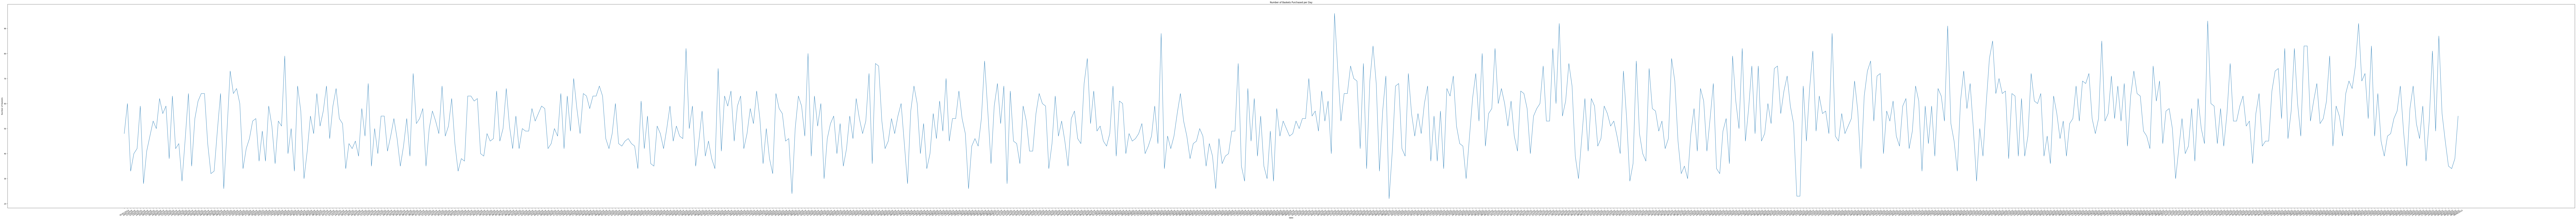

In [ ]:
# Tính số lượng giỏ hàng theo ngày
df_count = df.groupBy("Date","year","month","day").count()
df_count = df_count.orderBy(["year", "month", "day"], ascending=True)

# Chuyển đổi kết quả thành Pandas DataFrame để vẽ biểu đồ
pandas_df = df_count.toPandas()
plt.figure(figsize=(250, 20))
# Vẽ biểu đồ đường
plt.plot(pandas_df["Date"], pandas_df["count"])
plt.xlabel("Date")
plt.ylabel("Number of Baskets")
plt.title("Number of Baskets Purchased per Day")
plt.xticks(rotation=30)
plt.show()

In [ ]:
class PCY:
    def __init__(self, basket_file, s=0.3, c=0.5):
        self.basket_file = basket_file
        self.s = s
        self.c = c
        self.spark = SparkSession.builder.appName("PCY").getOrCreate()
        self.basket = self.create_basket()
        self.hash_table_size = 10  # Kích thước bảng băm
        self.hash_table = [0] * self.hash_table_size  # vector có giá trị 0 hoặc 1
        self.frequency_df = self.frequent_items()

    def create_basket(self):
        # Đọc file và tạo baskets
        df = self.spark.read.csv(self.basket_file).withColumn("STT", F.monotonically_increasing_id())
        df = df.withColumn("Basket", F.split(F.col("_c0"), ", "))
        df = df.select("STT", "Basket")
        return df

    def frequent_items(self):
        # Tìm danh sách frequency
        windowSpec = Window.orderBy("item")
        items_df = self.basket.select("Basket").withColumn("item", F.explode("Basket")).groupBy("item").count()
        items_df = items_df.withColumn("id", F.row_number().over(windowSpec))
        items_df = items_df.select("id", "item", "count")
        items_df = items_df.filter(F.col("count") > 1).orderBy(F.lower(F.col("item")))
        return items_df

    def hash_function(self, pair, item_ids):
        # Tính giá trị hash cho từng pair
        sum_hash = item_ids.get(pair[0], 0) + item_ids.get(pair[1], 0)
        return sum_hash % self.hash_table_size

    def create_hash_df(self, pairs, item_ids):
        # Xử lý bảng băm
        hash_values = [self.hash_function(pair, item_ids) for pair in pairs]
        hash_values_df = self.spark.createDataFrame(zip(pairs, hash_values), ["items", "id_bucket"])
        hash_values_df = hash_values_df.selectExpr("items._1 as item1", "items._2 as item2", "id_bucket")
        hash_table_df = hash_values_df.groupBy("id_bucket").count() \
                                      .filter(F.col("count") > (self.s * self.basket.count())) \
                                      .orderBy(F.col("count").asc())

        # Cập nhật bảng băm
        for row in hash_table_df.collect():
            id_bucket = row["id_bucket"]
            self.hash_table[id_bucket] = 1

        # Lọc dựa các bucket thoả mãn
        hash_values_df = hash_values_df.filter(F.col("id_bucket")  \
                                        .isin([id_bucket for id_bucket, value in enumerate(self.hash_table) if value == 1]))
        return hash_values_df

    def find_frequent_pairs(self):
        frequency_df = self.frequent_items()
        exploded_df = self.basket.select("STT", F.explode("Basket").alias("item"))

        # Loại bỏ các item không nằm trong frequency_df
        exploded_df_alias = exploded_df.alias("edf")
        modified_df = exploded_df_alias.join(
            frequency_df,
            exploded_df_alias["item"] == frequency_df["item"],
            "inner"
        ).groupBy("STT").agg(F.expr("collect_list(edf.item) as Basket"))
        # print("Number of baskets: ", modified_df.count())
        # exploded_df_alias.show()
        modified_df.show(5, truncate=False)
        # Tạo các cặp pair dựa trên baskets đã cập nhật
        pairs_with_freq = modified_df.rdd.flatMap(lambda row:
                                                  [(item1, item2)
                                                   for item1, item2 in combinations(sorted(row["Basket"]), 2)]).collect()
        # print("Number of frequent  pairs: ",len(pairs_with_freq))

        # Hash table (Xử lý bảng băm)
        item_ids = self.frequency_df.select("item", "id").rdd.collectAsMap()
        df_hash_table = self.create_hash_df(pairs_with_freq, item_ids)
        df_hash_table.show(5)

        # Count all pairs (Tìm frequent tất cả các pair thoả mãn điều kiện)
        df_hash_table = df_hash_table.groupBy("item1", "item2", "id_bucket").count()
        df_hash_table = df_hash_table.withColumnRenamed("count", "frequency")
        filtered_pairs_df = df_hash_table.filter(F.col("frequency") > (self.s * self.basket.count()))

        joined_df = filtered_pairs_df.join(frequency_df, filtered_pairs_df["item1"] == frequency_df["item"], "inner") \
                          .withColumnRenamed("count", "fr1")  \
                          .withColumnRenamed("id", "id1")     \
                          .drop("item")

        joined_df = joined_df.join(frequency_df, joined_df["item2"] == frequency_df["item"], "inner") \
                              .withColumnRenamed("count", "fr2")  \
                              .withColumnRenamed("id", "id2")     \
                              .select("id1", "item1",  "id2", "item2","frequency", "fr1", "fr2", "id_bucket" ) \
                              .orderBy(F.lower(F.col("item1")))
        return joined_df

    def find_association_rules(self, pairs_df):
        # Xử lý và tìm association rules
        total_baskets = self.basket.count()

        association_rules1_df = pairs_df.withColumn("confidence", F.col("frequency") / F.col("fr1"))                        \
                                        .withColumn("support", F.col("frequency") / total_baskets)                          \
                                        .withColumn("lift", F.col("confidence") / F.col("fr2") * total_baskets)             \
                                        .withColumnRenamed('item1', 'antecedent').withColumnRenamed('item2', 'consequent')  \
                                        .select("antecedent", "consequent", "confidence", "lift", "support")   \

        association_rules2_df = pairs_df.withColumn("confidence", F.col("frequency") / F.col("fr2"))                        \
                                        .withColumn("support", F.col("frequency") / total_baskets)                          \
                                        .withColumn("lift", F.col("confidence") / F.col("fr1") * total_baskets)             \
                                        .withColumnRenamed('item2', 'antecedent').withColumnRenamed('item1', 'consequent')  \
                                        .select("antecedent", "consequent", "confidence", "lift", "support")

        association_rules_df = association_rules1_df.union(association_rules2_df)               \
                                                    .filter(  (F.col("confidence")>= self.c)
                                                            & (F.col("support")   >= self.s))   \
                                                    .orderBy(F.lower(F.col("antecedent")))
        return association_rules_df

    def run(self):
        # self.frequent_items().show(truncate=False)

        # Find frequent pairs
        frequent_pairs = self.find_frequent_pairs()
        frequent_pairs.show(truncate=False)

        # Find association rules
        association_rules_df = self.find_association_rules(frequent_pairs)
        association_rules_df.show(5, truncate=False)

        frequent_pairs.toPandas().to_csv('pcy_frequent_pairs.csv')
        association_rules_df.toPandas().to_csv('pcy_association_rules.csv')

    def close(self):
        self.spark.stop()

spark = SparkSession.builder.getOrCreate()
pcy_instance = PCY('/content/baskets/*.csv',0.012,0.01)
pcy_instance.run()
pcy_instance.close()

+----+-----------------------------------+
|STT |Basket                             |
+----+-----------------------------------+
|26  |[frozen vegetables, tropical fruit]|
|29  |[pickled vegetables, citrus fruit] |
|474 |[margarine, whipped/sour cream]    |
|964 |[photo/film, root vegetables]      |
|1677|[chewing gum, dishes]              |
+----+-----------------------------------+
only showing top 5 rows

+-----------------+------------------+---------+
|            item1|             item2|id_bucket|
+-----------------+------------------+---------+
|frozen vegetables|    tropical fruit|        4|
|     citrus fruit|pickled vegetables|        1|
|        margarine|whipped/sour cream|        3|
|       photo/film|   root vegetables|        5|
|      chewing gum|            dishes|        6|
+-----------------+------------------+---------+
only showing top 5 rows

+---+----------------+---+----------+---------+----+----+---------+
|id1|item1           |id2|item2     |frequency|fr1 |fr